In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = 'EMB'  # emerging markets
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_emb.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%%**********************]  1 of 1 completed


Generating derived columns...
(4178, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2007-12-19,101.040001,101.220001,101.040001,101.220001,45.748867,3.823167,1.001781,1.000395,1.000889
2007-12-20,101.309998,101.309998,101.260002,101.260002,45.766937,3.823562,0.999507,0.998913,1.002370
2007-12-21,101.500000,101.540001,101.029999,101.150002,45.717209,3.822475,0.996552,1.001779,1.001780
2007-12-24,101.330002,101.330002,101.330002,101.330002,45.798553,3.824253,1.000000,1.000790,0.999605
2007-12-26,101.290001,101.410004,101.290001,101.410004,45.834728,3.825042,1.001185,0.999219,0.998422
2007-12-27,101.250000,101.250000,101.099998,101.169998,45.798916,3.824260,0.999210,1.000396,1.000297
2007-12-28,101.199997,101.209999,101.169998,101.209999,45.817047,3.824656,1.000099,1.001383,1.001581
2007-12-31,101.370003,101.400002,101.349998,101.349998,45.880432,3.826039,0.999803,1.001381,0.998027
2008-01-02,101.150002,101.529999,101.150002,101.489998,45.943798,3.827419,1.003361,1.001774,1.002759


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
2007-12-19    101.220001
2007-12-20    101.309998
2007-12-21    101.540001
2007-12-26    101.410004
2007-12-27    101.250000
                 ...    
2024-07-22     89.930000
2024-07-23     89.930000
2024-07-24     89.800003
2024-07-25     89.629997
2024-07-26     89.894997
Name: high, Length: 4173, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2010-01-04')  # first day of legit open/close values
SIM_START

Timestamp('2010-01-04 00:00:00')

In [7]:
len(df.index >= SIM_START)

4178

In [8]:
df[df.index >= SIM_START]

,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2010-01-04,101.739998,101.930000,101.330002,101.930000,51.884308,3.949016,1.001868,1.006082,1.002747
2010-01-05,102.209999,102.580002,102.070000,102.550003,52.199883,3.955080,1.003327,1.001366,1.000488
2010-01-06,102.599998,102.750000,102.230003,102.690002,52.271172,3.956445,1.000877,0.994839,0.996981
2010-01-07,102.379997,102.510002,102.099998,102.160004,52.001377,3.951270,0.997851,1.001175,1.001175
2010-01-08,102.279999,102.489998,102.180000,102.279999,52.062504,3.952445,1.000000,1.007625,1.007235
...,...,...,...,...,...,...,...,...,...
2024-07-22,89.610001,89.930000,89.519997,89.660004,89.660004,4.496025,1.000558,1.000335,1.000223
2024-07-23,89.680000,89.930000,89.680000,89.690002,89.690002,4.496359,1.000112,0.993533,0.998996
2024-07-24,89.599998,89.800003,89.110001,89.110001,89.110001,4.489872,0.994531,1.001683,1.001571


In [9]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear']), #'linear_ma']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [10]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [11]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

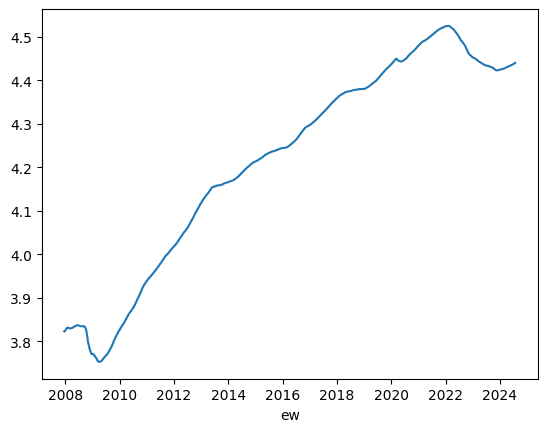

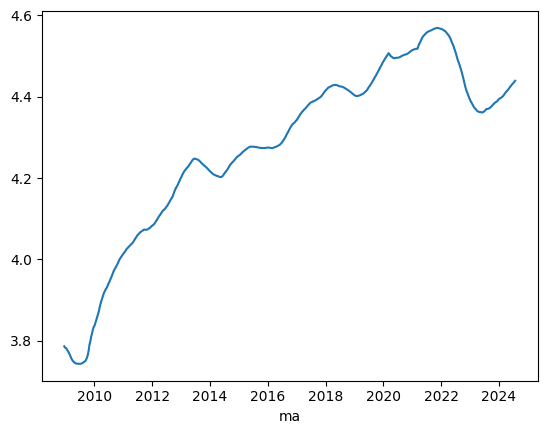

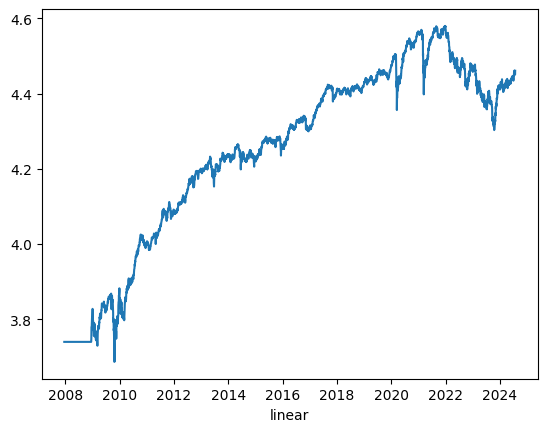

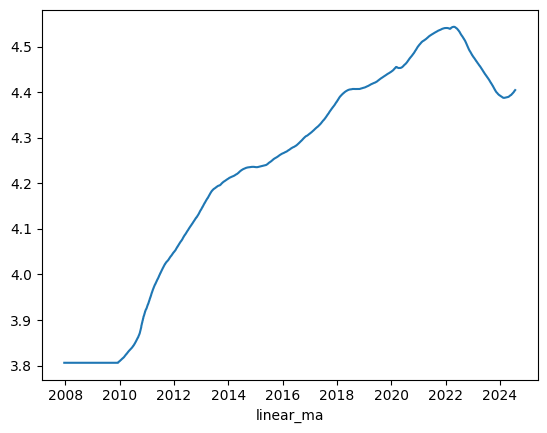

In [12]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [13]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [14]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [15]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [16]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [17]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [18]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params #= None, None

(2.6465838535836146,
 {'time_param': 6,
  'method': 'linear',
  't': 0.8597521934336938,
  'k': 7.887614799063902,
  'as_q': True,
  'transform_f': 'bounded_curve'})

Do nothing res: 1.7300028821071145
Round 1: 2.677830836765202
New best: 2.677830836765202
{'time_param': 6, 'method': 'linear', 't': 0.8597521934336938, 'k': 7.887614799063902, 'as_q': True, 'transform_f': 'bounded_curve'}


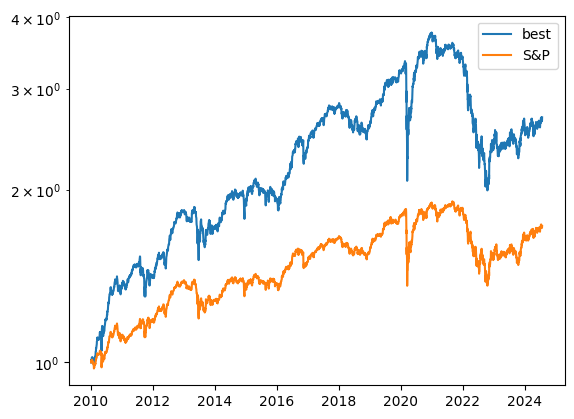

Round 2: 1.2722388593572145
Round 3: 1.6073780919134213
Round 4: 2.285968436923974
Round 5: 2.1354729680057436
Round 6: 1.2879617736509192
Round 7: 1.0676977728067414
Round 8: 1.0608769679939956
Round 9: 1.1856561374914503
Round 10: 2.085245522729611
Round 11: 2.4753258320485374
Round 12: 1.09315499302573
Round 13: 1.0581433404924423
Round 14: 2.3542401637723707
Round 15: 1.0554225450133021
Round 16: 2.201830091706979
Round 17: 1.0560233418931715
Round 18: 1.0177492781990827
Round 19: 1.5784560074228007
Round 20: 2.0465298040421733
Round 21: 1.927438595341592
Round 22: 1.041279825897799
Round 23: 2.452251699324095
Round 24: 1.08716895966442
Round 25: 1.4791706041278125
Round 26: 2.2757578506335223
Round 27: 1.3580816605864365
Round 28: 1.2114370185151704
Round 29: 1.5221631062706178
Round 30: 1.79354123498144
Round 31: 1.6917750856839875
Round 32: 1.995004654334555
Round 33: 1.5891020234680195
Round 34: 1.4587307977639545
Round 35: 1.38269085041575
Round 36: 1.9905313263094349
Round 37

In [19]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 1.7300028821071145
Round 1: 2.516081591607028
Round 2: 2.45120726553182
Round 3: 2.468514742309348
Round 4: 2.533414127504173
Round 5: 2.4685141938925406
Round 6: 2.6848215088870484
New best: 2.6848215088870484
{'time_param': 5, 'method': 'linear', 't': 0.9808351982281224, 'k': 7.950812032136424, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


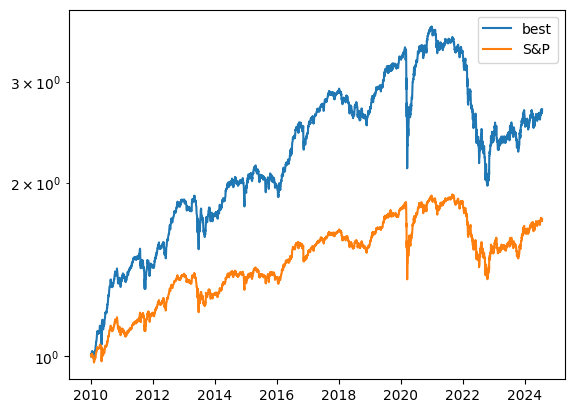

Round 7: 2.468410755466059
Round 8: 2.4684189054519234
Round 9: 1.0299520164103098
Round 10: 2.4684345039388234
Round 11: 1.457769749753742
Round 12: 1.777476373202789
Round 13: 2.4684204024674035
Round 14: 0.8892419389951715
Round 15: 2.4685151394882716
Round 16: 2.4684058618601665
Round 17: 2.4684003508336
Round 18: 2.4684003905222434
Round 19: 2.468401409796781
Round 20: 2.4684398908253313
Round 21: 1.133271326260049
Round 22: 2.0515438005570292
Round 23: 2.0198535302257037
Round 24: 2.574942989914021
Round 25: 2.4684042343236325

Factor: 1.03125
Do nothing res: 1.7300028821071145
Round 1: 2.4684233199008827
Round 2: 2.4684245122234914
Round 3: 2.468413460634244
Round 4: 2.4684139279209956
Round 5: 2.468420967075095
Round 6: 1.9252152936125468
Round 7: 2.468418265783562
Round 8: 2.4684157739560857
Round 9: 2.468430187542979
Round 10: 2.4684252063423093
Round 11: 2.532378696413389
Round 12: 0.962280800279171
Round 13: 2.4684317475113344
Round 14: 2.4612339926007056
Round 15: 1.939923

In [20]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [21]:
# Force set:
#best_out = 1.785863355710255
#params_out = {'time_param': 160, 'method': 'linear', 't': 0.8604701020371026, 'k': 6.0009414899488185, 'as_q': True, 'transform_f': 'bounded_sigmoid'}

In [22]:
final_out = simulate(df, params_out)

In [23]:
amt_in = final_out['amt_in'][-1]
amt_in

1.0

In [24]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.49341632750778075

In [25]:
params_out

{'time_param': 5,
 'method': 'linear',
 't': 0.9808351982281224,
 'k': 7.950812032136424,
 'as_q': True,
 'transform_f': 'bounded_sigmoid'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)
/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: overflow encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


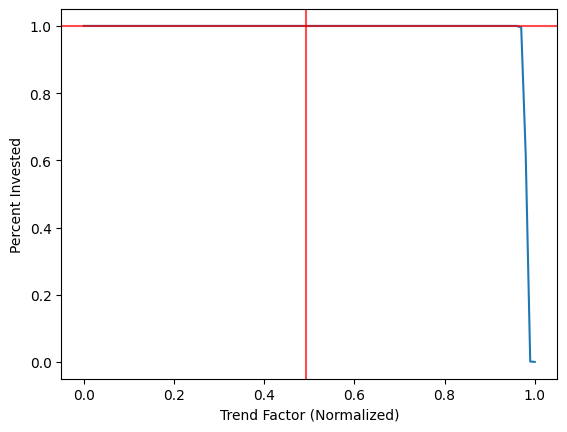

In [26]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

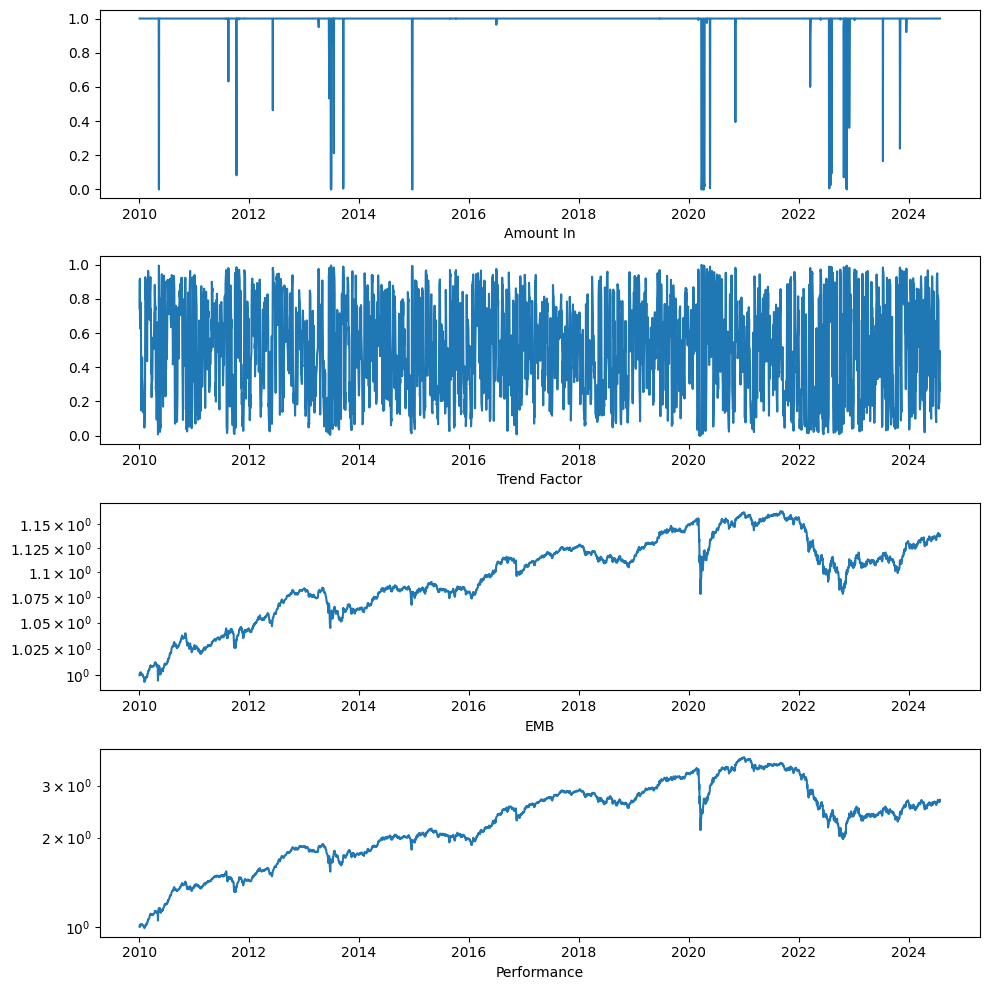

In [27]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('EMB')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [28]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('EMB')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

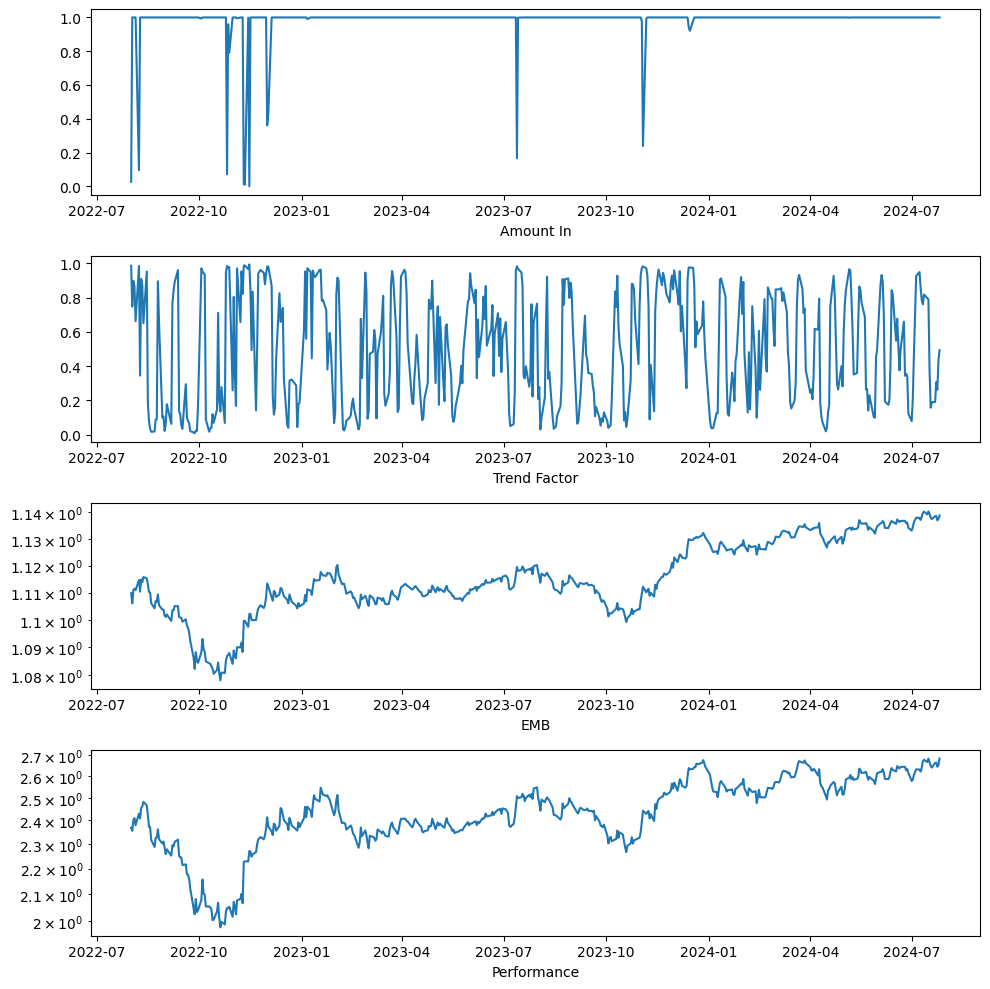

In [29]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('EMB')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [30]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

1.0

In [31]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(51.884307861328125, 14.66, 89.76000213623047)

In [32]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.06968900525355992

In [33]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['emb'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.1166760869542303, 1.0], 'nas': [1.2304992309873917, 1.0], 'rus': [1.2742819903991893, 1.0], 'jpxn': [1.0677407555494602, 0.0003], 'ktec': [1.6545381088690727, 0.0], 'emb': [1.06968900525356, 1.0], 'gdx': [1.3475698750559093, 0.9627], 'dia': [1.2021528651895483, 1.0]}


In [34]:
stop

NameError: name 'stop' is not defined

In [35]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(2.6848215088870484,
 {'time_param': 5,
  'method': 'linear',
  't': 0.9808351982281224,
  'k': 7.950812032136424,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})